## **Paper:** Multi-objective Parameter Tuning with Dynamic Compositional Surrogate Models

In [1]:
import glob
import warnings
warnings.filterwarnings('ignore')
# import sys
# sys.path.append('..')
# sys.path.append('../src')

import pandas as pd
import numpy as np
from numpy import nan
import pygmo as pg
import seaborn as sns
import matplotlib.pyplot as plt

from plotly import graph_objs as go
import plotly.express as px

sns.set(context='talk', style="whitegrid", font_scale=2, rc={'figure.figsize': {24, 13}})


def get_data(path):
    df_group = [pd.read_pickle(i_path) for i_path in glob.glob(path)]
    return pd.concat(df_group)

def make_nd_pop(pro, x, y):
    nd_front = pg.fast_non_dominated_sorting(y)[0][0]
    nd_x = np.array(x)[nd_front]
    nd_y = np.array(y)[nd_front]
    t_pop = pg.population(pro)
    for i, p_vector in enumerate(nd_x):
        t_pop.push_back(x=p_vector, f=nd_y[i])
    return t_pop

def add_ndf_size(hmapper_df):
    map_copy = hmapper_df.copy()
    ndf_size = []
    for i in range(len(map_copy)):
        if i < 2:
            ndf_size.append(1)
        else:
            temp_obj = map_copy.iloc[:i+1][['f1','f2']].values
            index_ndf, dl, dc, ndr = pg.fast_non_dominated_sorting(temp_obj)
            ndf_size.append(len(index_ndf[0])) # 0 - last best pareto front
    map_copy['ndf_size'] = ndf_size
    return map_copy


### Colect results
It should be noted that in the tables the `hypervolume` value is expressed in accordance with the **currently** evaluated samples. This means that to compare *multiple* optimization experiments, we need to calculate a **common reference point** and recalculate all hypervolume values.

In [2]:
# --- TutorM
b1_df = get_data('./data/tutorm/paper/bench_1/WFG12_10_paper_tutor_loop.*.pkl')
b2_df = get_data('./data/tutorm/paper/bench_2/WFG12_10_paper_tutor_loop.*.pkl')
b3_df = get_data('./data/tutorm/paper/bench_3/WFG12_10_paper_tutor_loop.*.pkl')
b4_df = get_data('./data/tutorm/default_tutor/*/WFG12_10_default_tutor_loop.*.pkl')

# --- Fix model
# fix_model = get_data('./data/tutorm/paper/ndf_samples100_singl_model/WFG12_10_paper_tutor_loop.*.pkl')
# fix_model['model name'] = fix_model['model name'].astype(str)

# [2] sobol sampling
# ===================== Etalon
keys = get_data('./data/tutorm/paper/solo_model_WFG1/lhs_init100/WFG12_10_paper_tutor_loop.*.pkl')[['params hash', 'model name']]
keys['params hash'] = keys['params hash'].astype(str)
keys['model name'] = keys['model name'].astype(str)
keys.drop_duplicates(inplace=True, ignore_index=True)

target = get_data('./data/tutorm/paper/solo_model_WFG1/sobol_init100/dropped_name/WFG12_10_paper_tutor_loop.*.pkl')
target['params hash'] = target['params hash'].astype(str)
target.drop('model name', axis=1, inplace=True)

fix_model = pd.merge(target, keys, how='left', on='params hash')
df_svr = get_data('./data/tutorm/paper/solo_model_WFG1/sobol_init100/WFG12_10_paper_solo_loop.*.pkl')
df_svr['model name'] = df_svr['model name'].astype(str)
fix_model = pd.concat([fix_model,df_svr])
fix_model = fix_model[fix_model['model name']!='nan']

# --- NSGA2
nsga2_df = pd.read_csv('./data/moea/concat/nsga2_on_WFG1_22_750k.csv').query('i_fevals<=1000')
nsga2_df.rename(columns={"f_0": "f1", "f_1": "f2"}, inplace=True)
# baseline for reference point
baseline_df = pd.read_csv('./data/moea/concat/nsga2_on_WFG1_22_750k.csv').query('i_fevals==50000')
baseline_df.rename(columns={"f_0": "f1", "f_1": "f2"}, inplace=True)
# --- NSGA2 50k
nsga2_50k_df = pd.read_csv('./data/moea/concat/nsga2_on_WFG1_22_750k.csv')
nsga2_50k_df.rename(columns={"f_0": "f1", "f_1": "f2"}, inplace=True)
selection = nsga2_50k_df['group_id'].unique()[0]
nsga2_50k_df = nsga2_50k_df[nsga2_50k_df['group_id']==selection]


# --- Hypermapper
mapper_path = './data/hypermapper/all_5x/WFG1_*_output_samples.csv'
mapper_df = pd.concat([add_ndf_size(pd.read_csv(i_path)) for i_path in glob.glob(mapper_path)])

# select 5 experiments (available 10)
selection = b4_df['tutor_id'].unique()[:5]
b4_df = b4_df[b4_df['tutor_id'].isin(selection)]

# --- bench columns for plots
b1_df['approach:'] = 'TutorM: Section 5.2'
b2_df['approach:'] = 'TutorM: Section 5.3'
b3_df['approach:'] = 'TutorM: stack+val init:100'
b4_df['approach:'] = 'TutorM: Section 5.4'
nsga2_df['approach:'] = 'NSGA-II'
mapper_df['approach:'] = 'Hypermapper 2.0'
fix_model['approach:'] = fix_model['model name']

gpr = fix_model[fix_model['model name'] == 'gaussianprocessregressor']
gpr['approach:'] = 'GPR'
gpr_gpr = fix_model[fix_model['model name'] == "['gaussianprocessregressor', 'gaussianprocessregressor']"]
gpr_gpr['approach:'] = '[GPR,GPR]'
svr_svr = fix_model[fix_model['model name'] == "['svr', 'svr']"]
svr_svr['approach:'] = '[SVR,SVR]'
# mlp_mlp = fix_model[fix_model['model name'] == "['mlpregressor', 'mlpregressor']"]
# mlp_mlp['approach:'] = '[MLPR,MLPR]'
# gbr_gbr = fix_model[fix_model['model name'] == "['gradientboostingregressor', 'gradientboostingregressor']"]
# gbr_gbr['approach:'] = '[GBR,GBR]'

# --- Common reference points for all experiments (benchmarks 1, 2, 3, 4)
tutorm_objectives = np.concatenate([np.concatenate(df.pop_ndf_y.values) for df in [b1_df, b2_df, b3_df, b4_df, fix_model]])
all_objectives = np.concatenate([tutorm_objectives, nsga2_df[['f1', 'f2']].values, mapper_df[['f1', 'f2']].values, nsga2_50k_df[['f1', 'f2']].values])
ref_point = np.amax(all_objectives, axis=0).tolist()

# --- Update Hypervolume
def upd_hypervolume(row, ref_point):
    hypervolume = pg.hypervolume(row['pop_ndf_y']).compute(ref_point)
    row.hypervolume = hypervolume
    return row

def upd_hypervolume_moea(focus_df, ref_point):
    df_copy = focus_df.copy()
    obj = df_copy[['f1', 'f2']].values
    hypervolume = []
    for i in range(len(df_copy)):
        if i < 2:
            hypervolume.append(0)
        else:
            hypervolume.append(pg.hypervolume(obj[:i+1]
                                         ).compute(ref_point))
    df_copy['hypervolume'] = hypervolume
    return df_copy

In [3]:
b1_df = b1_df.apply(lambda row: upd_hypervolume(row, ref_point), axis=1)
b2_df = b2_df.apply(lambda row: upd_hypervolume(row, ref_point), axis=1)
b3_df = b3_df.apply(lambda row: upd_hypervolume(row, ref_point), axis=1)
b4_df = b4_df.apply(lambda row: upd_hypervolume(row, ref_point), axis=1)
# fix_model = fix_model.apply(lambda row: upd_hypervolume(row, ref_point), axis=1)
gpr_df = gpr.apply(lambda row: upd_hypervolume(row, ref_point), axis=1)
gpr_gpr_df = gpr_gpr.apply(lambda row: upd_hypervolume(row, ref_point), axis=1)
svr_svr_df = svr_svr.apply(lambda row: upd_hypervolume(row, ref_point), axis=1)
# mlp_mlp_df = mlp_mlp.apply(lambda row: upd_hypervolume(row, ref_point), axis=1)
# gbr_gbr_df = gbr_gbr.apply(lambda row: upd_hypervolume(row, ref_point), axis=1)

In [4]:
nsga2_df = upd_hypervolume_moea(nsga2_df, ref_point)
mapper_df = upd_hypervolume_moea(mapper_df, ref_point)
mapper_df = mapper_df.reset_index().rename(columns={"index": "i_fevals"})
mapper_df.i_fevals = mapper_df.i_fevals + 1
mapper_df = mapper_df.query('i_fevals>=100')
nsga2_50k_df = upd_hypervolume_moea(nsga2_50k_df, ref_point)
# -------------- !!!!!! 

In [5]:
# --- Sort values for proper plotting
b1_df.sort_values(by='i_fevals', ascending=False, inplace=True)
b2_df.sort_values(by='i_fevals', ascending=False, inplace=True)
b3_df.sort_values(by='i_fevals', ascending=False, inplace=True)
b4_df.sort_values(by='i_fevals', ascending=False, inplace=True)
# fix_model.sort_values(by='i_fevals', ascending=False, inplace=True)
gpr_df.sort_values(by='i_fevals', ascending=False, inplace=True)
gpr_gpr_df.sort_values(by='i_fevals', ascending=False, inplace=True)
svr_svr_df.sort_values(by='i_fevals', ascending=False, inplace=True)
# mlp_mlp_df.sort_values(by='i_fevals', ascending=False, inplace=True)
# gbr_gbr_df.sort_values(by='i_fevals', ascending=False, inplace=True)

mapper_df.sort_values(by='i_fevals', ascending=False, inplace=True)


# Average hypervolume for population:
nsga2_50k_avg = nsga2_50k_df.groupby(['i_fevals']).mean().reset_index()
nsga2_50k_avg['approach:'] = 'baseline: nsga2'

### Rescale Hypervolume

- **max** is hypervolume from NSGA2 with `50 000` functions evalutions
- **min** is minimal hypervolume from non-dominated solutions in 10 random points

In [6]:
# ---- Baseline [max]
# baseline_df = pd.read_csv('./data/moea/concat/nsga2_on_WFG1_22_750k.csv').query('i_fevals==50000')
# baseline_df.rename(columns={"f_0": "f1", "f_1": "f2"}, inplace=True)
# max_hv = baseline_df.groupby(['group_id']).apply(upd_hypervolume_moea, ref_point).mean().hypervolume
max_hv = nsga2_50k_df.query('i_fevals==50000').hypervolume.unique().max()


# ---- Min
udp = pg.wfg(prob_id=1, dim_dvs=2, dim_obj=2, dim_k=1)  # == WFG
pro = pg.problem(udp)
pop = pg.population(pro, size=10, seed=42)
min_hv = pg.hypervolume(make_nd_pop(pro, pop.get_x(), pop.get_f()).get_f()).compute(ref_point)


## Overall comparison: Portfolio(TutorM) vs Static surrogate

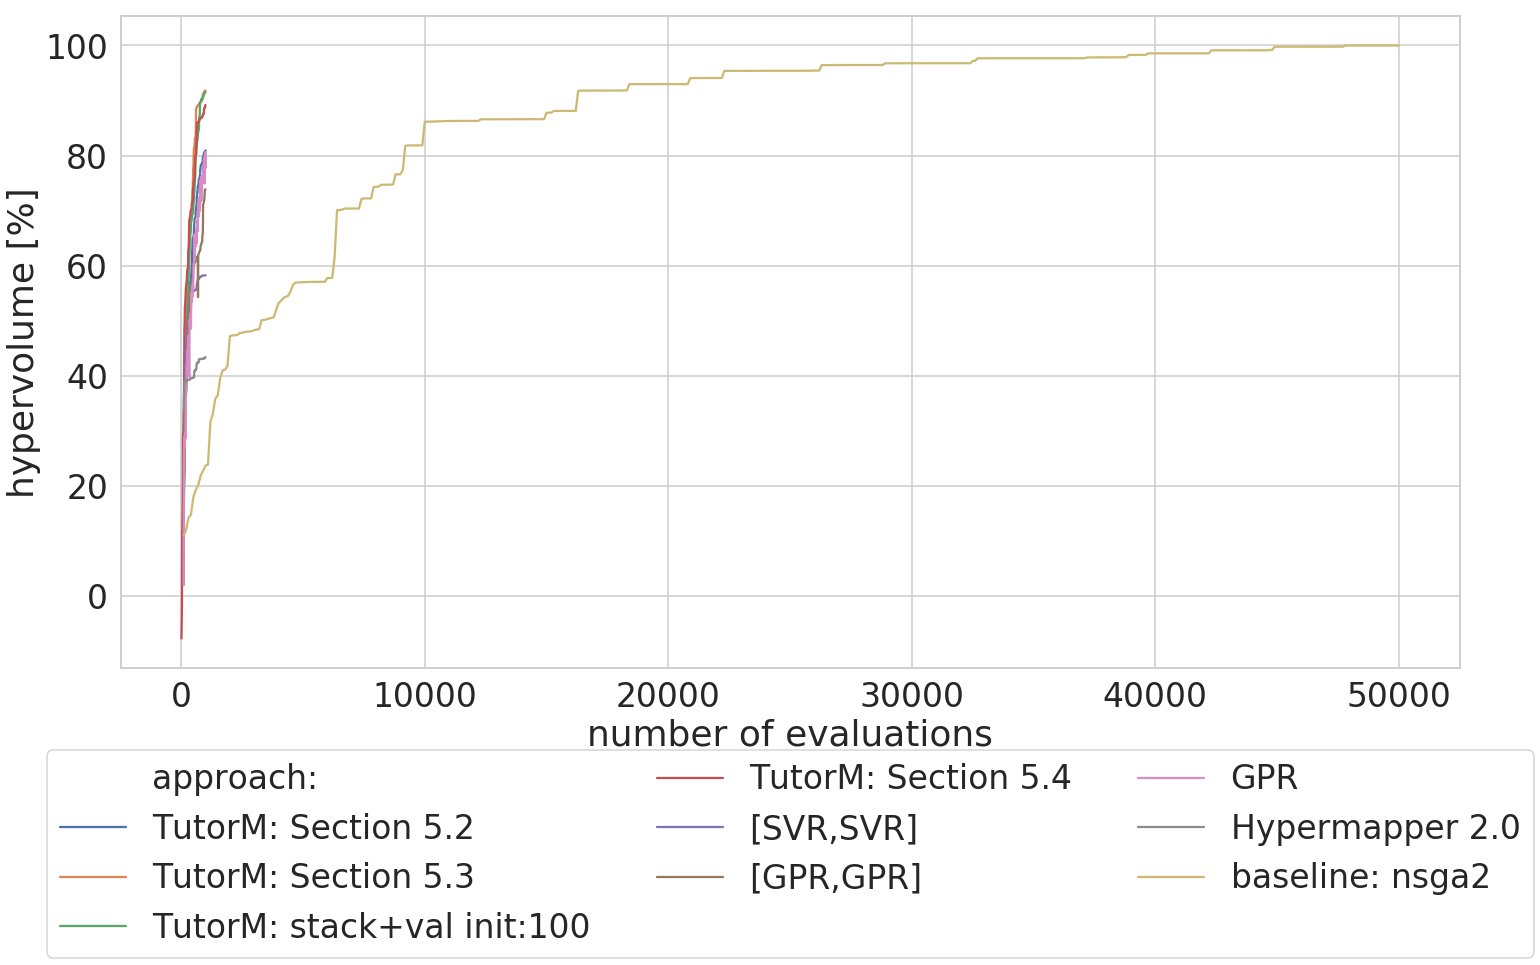

In [7]:
# + mlp_mlp_df, gbr_gbr_df
df_list = [b1_df, b2_df, b3_df, b4_df, svr_svr_df, gpr_gpr_df, gpr_df, mapper_df, nsga2_50k_avg]
    
def rescale_df(df, min_hv, max_hv):
    df_copy = df.copy()
    df_copy['hypervolume'] = ((df_copy['hypervolume']-min_hv)/(max_hv-min_hv))*100
    return df_copy

plt.figure(figsize=(24, 12))
p = sns.lineplot(x="i_fevals", y="hypervolume", hue="approach:", markers=True,
             palette="deep", ci=None,
             data=pd.concat([rescale_df(temp_df, min_hv, max_hv) for temp_df in df_list]))
p.set(xlabel="number of evaluations")
p.set(ylabel="hypervolume [%]")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),  ncol=3)
# plt.savefig('basic.pdf', bbox_inches = 'tight')

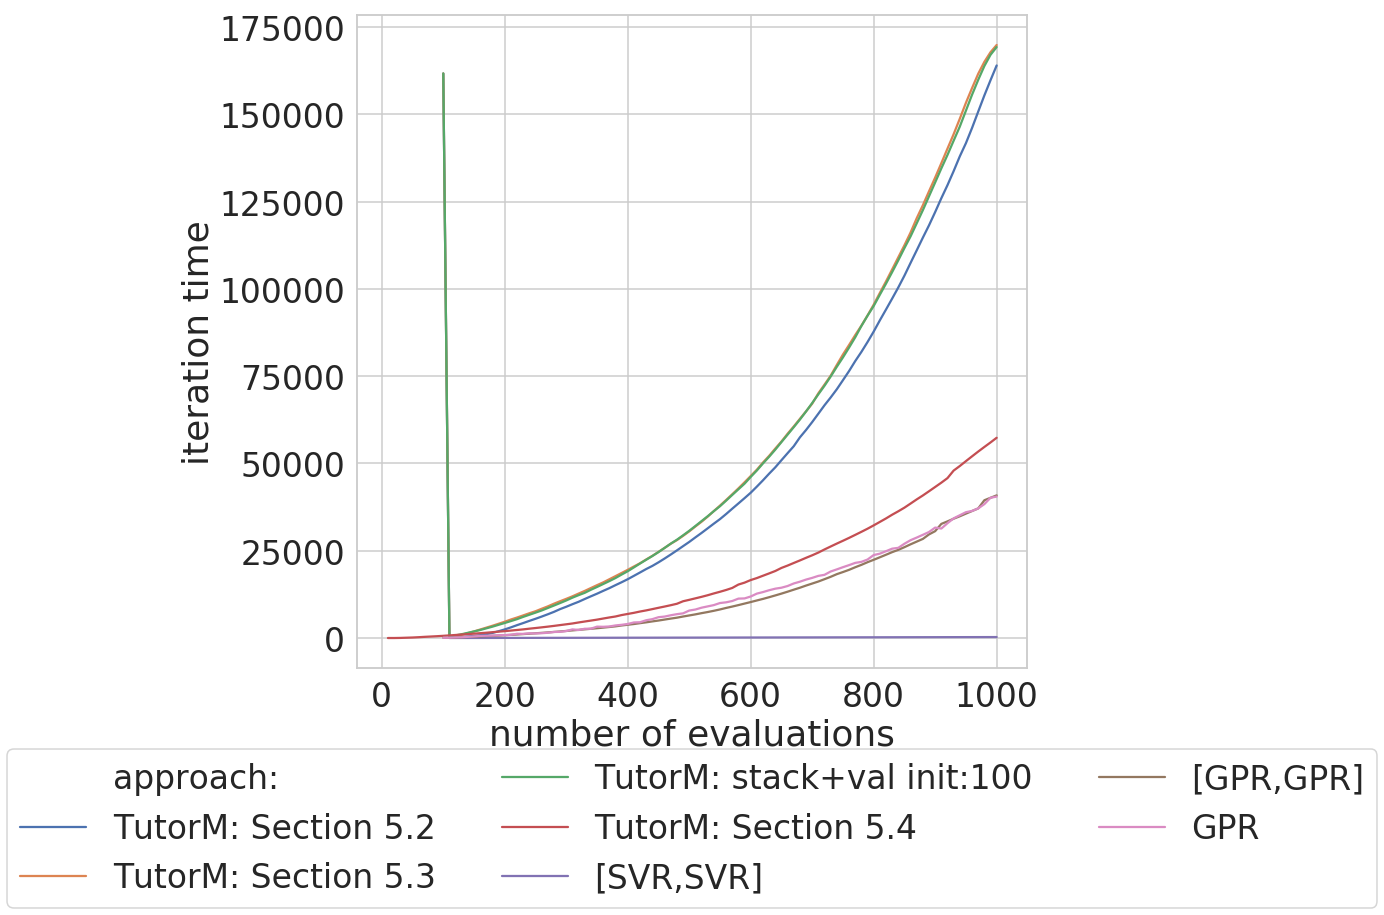

In [51]:
data = pd.concat([b1_df, b2_df, b3_df, b4_df, svr_svr_df, gpr_gpr_df, gpr_df])
# data.i_time.astype(float)
dt = []
for index, row in data.iterrows():
    if type(row['i_time']) != str:
        dt.append(row)
data = pd.DataFrame(dt)

plt.figure(figsize=(12, 12))
p = sns.lineplot(x="i_fevals", y="i_time", hue="approach:", markers=True,
             palette="deep", ci=None,
             data=data)
p.set(xlabel="number of evaluations")
p.set(ylabel="iteration time")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),  ncol=3)


## Extra plots

In [ ]:
for temp_df in [b1_df, b2_df, b3_df, b4_df, mlp_mlp_df, svr_svr_df, gbr_gbr_df, gpr_gpr_df, gpr_df, nsga2_df, mapper_df, nsga2_50k_df]:
    temp_df['hypervolume'] = ((temp_df['hypervolume']-min_hv)/(max_hv-min_hv))*100
nsga2_50k_df

In [ ]:
plt.figure(figsize=(24, 12))
p = sns.lineplot(x="i_fevals", y="hypervolume", hue="approach:", markers=True,
             palette="deep", ci=None,
             data=pd.concat([mapper_df, mlp_mlp_df, svr_svr_df, gbr_gbr_df,gpr_gpr_df, gpr_df, b1_df, b2_df, b4_df, nsga2_50k_df]))
p.set(xlabel="number of evaluations")
p.set(ylabel="hypervolume [%]")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),  ncol=3)

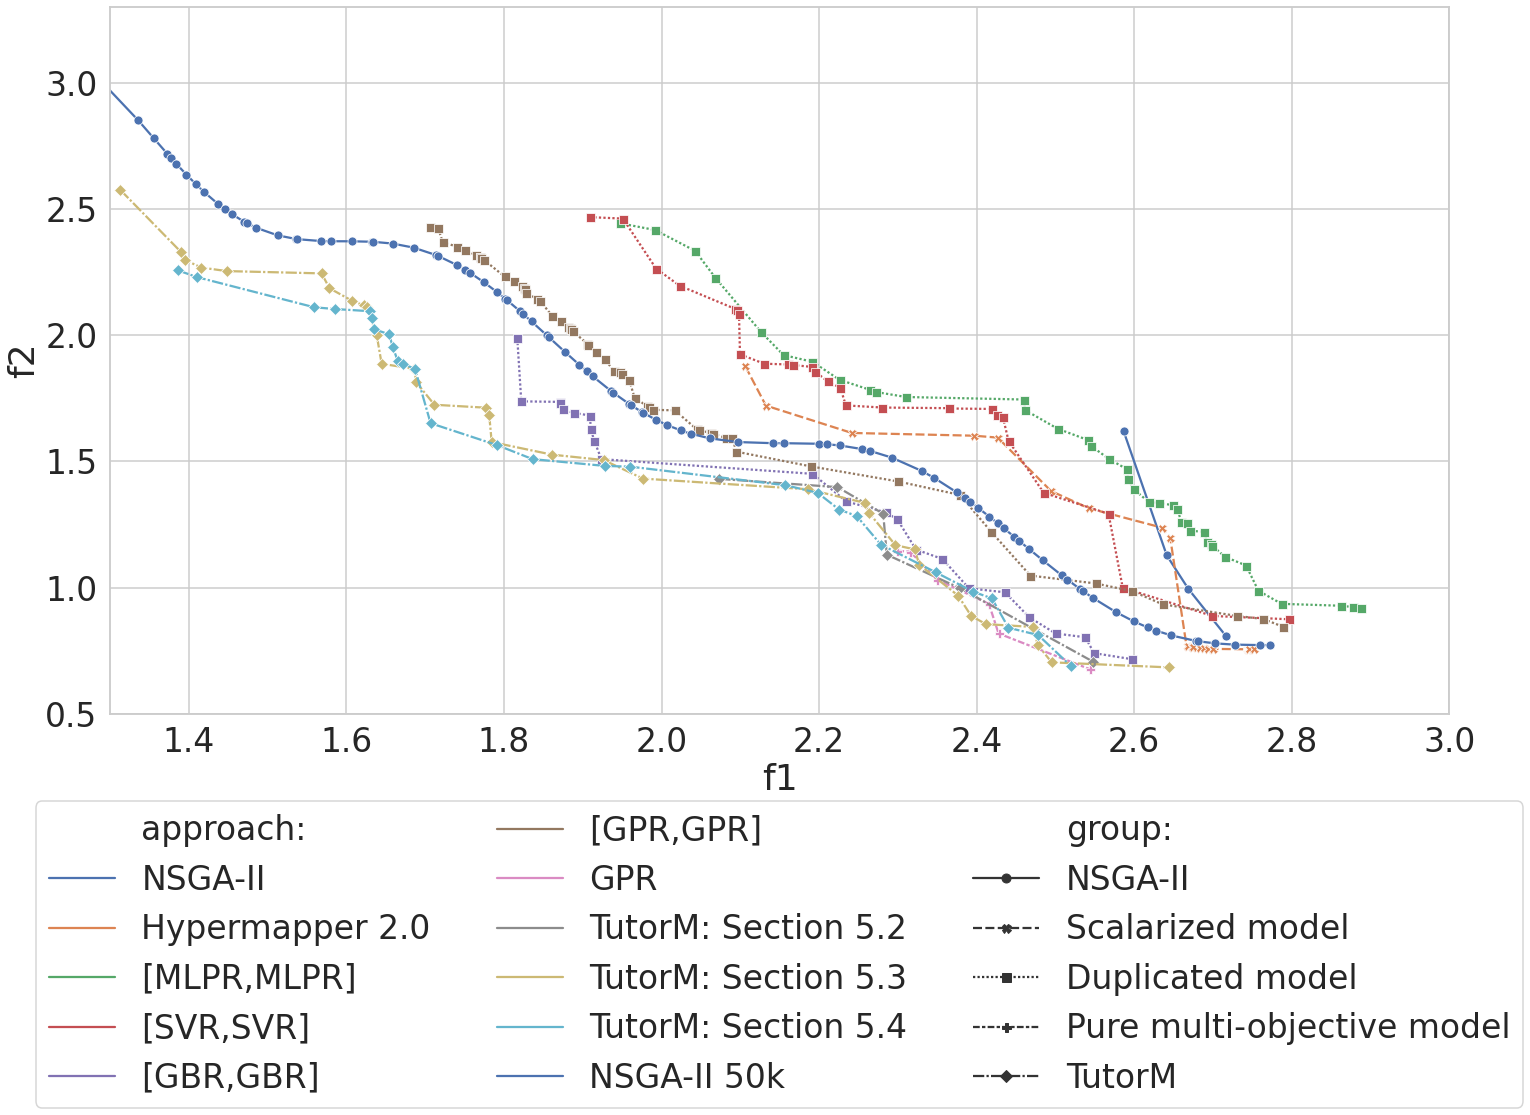

In [40]:
EXP_ORDER = 0  # 0-4

# plt.figure(figsize=(24, 12))
summ = []


# --- NSGA2
all_points = nsga2_df.groupby('i_fevals').apply(lambda focus_df: focus_df.iloc[EXP_ORDER])
index_ndf, dl, dc, ndr = pg.fast_non_dominated_sorting(all_points[['f1','f2']].values)
temp_nsga2 = all_points.iloc[index_ndf[0]][['f1', 'f2', 'approach:']]


# temp_nsga2 = list(nsga2_df.query('i_fevals==1000').groupby('group_id'))[EXP_ORDER][1]
# temp_nsga2 = temp_nsga2[['f1', 'f2', 'approach:']]

temp_nsga2['group:'] = 'NSGA-II'

summ.append(temp_nsga2)

# --- Hypermapper

all_points = mapper_df.groupby('i_fevals').apply(lambda focus_df: focus_df.iloc[EXP_ORDER])
index_ndf, dl, dc, ndr = pg.fast_non_dominated_sorting(all_points[['f1','f2']].values)
temp_mapper = all_points.iloc[index_ndf[0]][['f1','f2','approach:']]
temp_mapper['group:'] = 'Scalarized model'
temp_mapper['approach:'] = "Hypermapper 2.0"

summ.append(temp_mapper)

# --- Duplicated models
for temp_df in [mlp_mlp, svr_svr, gbr_gbr, gpr_gpr]:
    i_result = temp_df.query('i_fevals==1000').iloc[EXP_ORDER]
    temp_static = pd.DataFrame(i_result.pop_ndf_y, columns=['f1', 'f2'])
    temp_static['approach:'] = i_result['approach:']
    temp_static['group:'] = 'Duplicated model'
    summ.append(temp_static)

# --- Pure multi-objective models
for temp_df in [gpr]:
    i_result = temp_df.query('i_fevals==1000').iloc[EXP_ORDER]
    temp_static = pd.DataFrame(i_result.pop_ndf_y, columns=['f1', 'f2'])
    temp_static['approach:'] = i_result['approach:']
    temp_static['group:'] = 'Pure multi-objective model'
    summ.append(temp_static)

# --- TutorM
for temp_df in [b1_df, b2_df, b4_df]:
    i_result = temp_df.query('i_fevals==1000').iloc[EXP_ORDER]
    temp_tutor = pd.DataFrame(i_result.pop_ndf_y, columns=['f1', 'f2'])
    temp_tutor['approach:'] = i_result['approach:']
    temp_tutor['group:'] = 'TutorM'
    summ.append(temp_tutor)

# --- [Baseline] NSGA2 50k
temp_base = list(baseline_df.groupby('group_id'))[EXP_ORDER][1]
temp_base = temp_base[['f1', 'f2']]
temp_base['group:'] = 'NSGA-II'
temp_base['approach:'] = 'NSGA-II 50k'
summ.append(temp_base)

# sns.set(font_scale=2)
sns.lineplot(data=pd.concat(summ), x='f1', y='f2', markers=True, palette="deep", style="group:", hue='approach:')
plt.xlim(1.3, 3)
plt.ylim(0.5, 3.3)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.savefig('pareto.pdf', bbox_inches = 'tight')


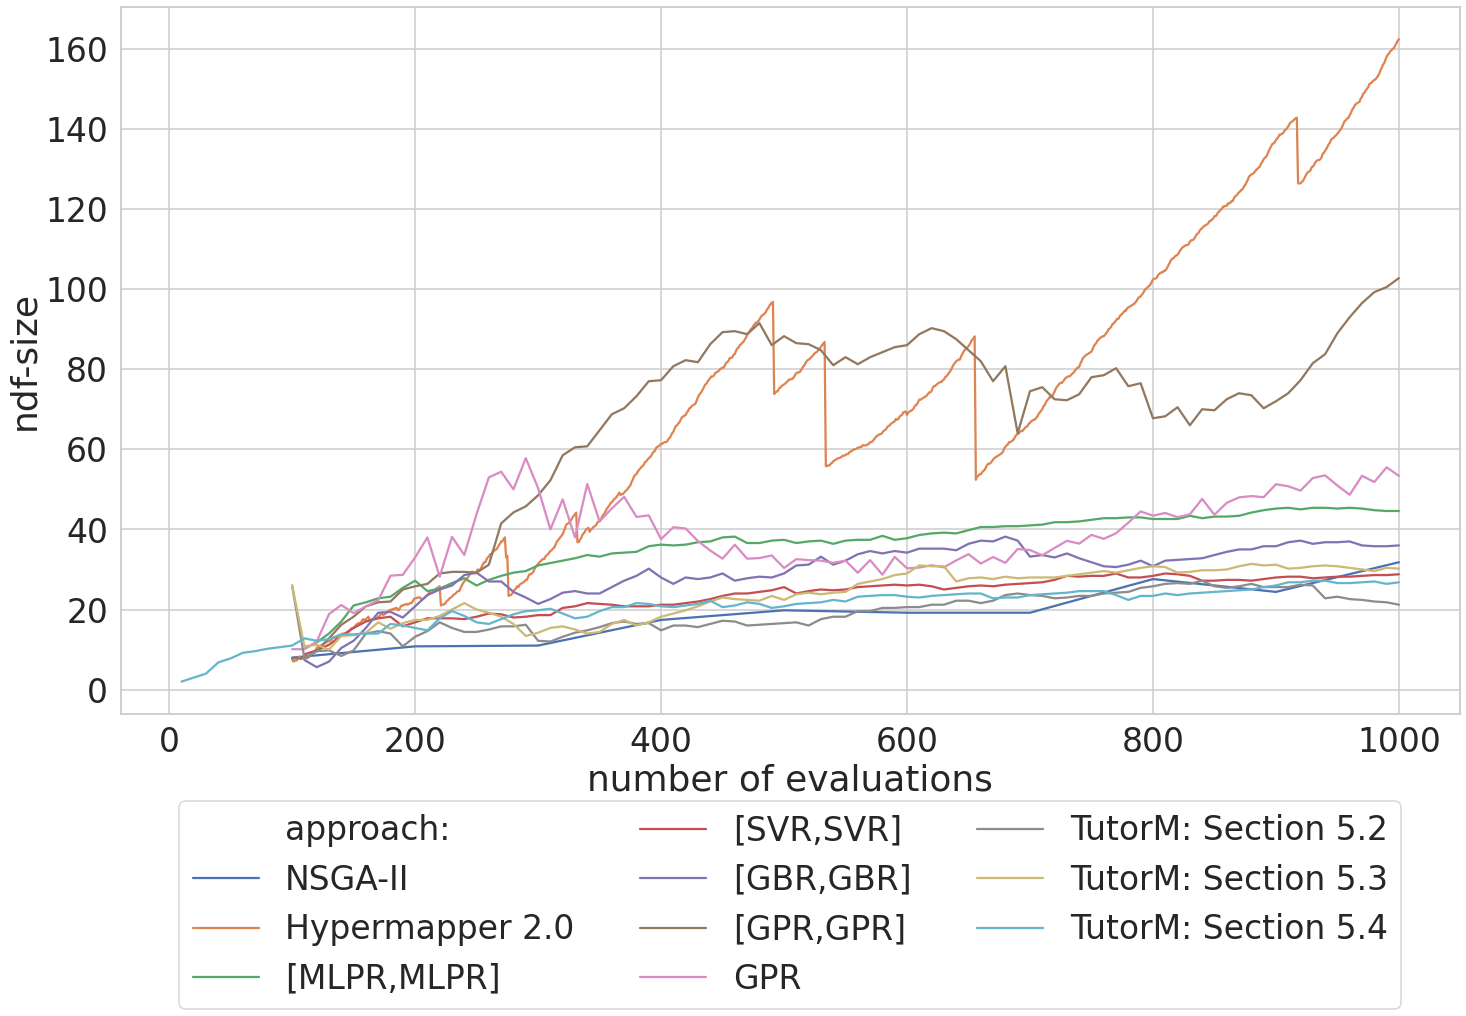

In [41]:
p = sns.lineplot(x="i_fevals", y="ndf_size", hue="approach:",
             palette="deep", ci=None,
             data=pd.concat([nsga2_df, mapper_df, mlp_mlp, svr_svr, gbr_gbr,gpr_gpr, gpr, b1_df, b2_df, b4_df]))
p.set(xlabel="number of evaluations")
p.set(ylabel="ndf-size")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),  ncol=3)
plt.savefig('ndf.pdf', bbox_inches = 'tight')

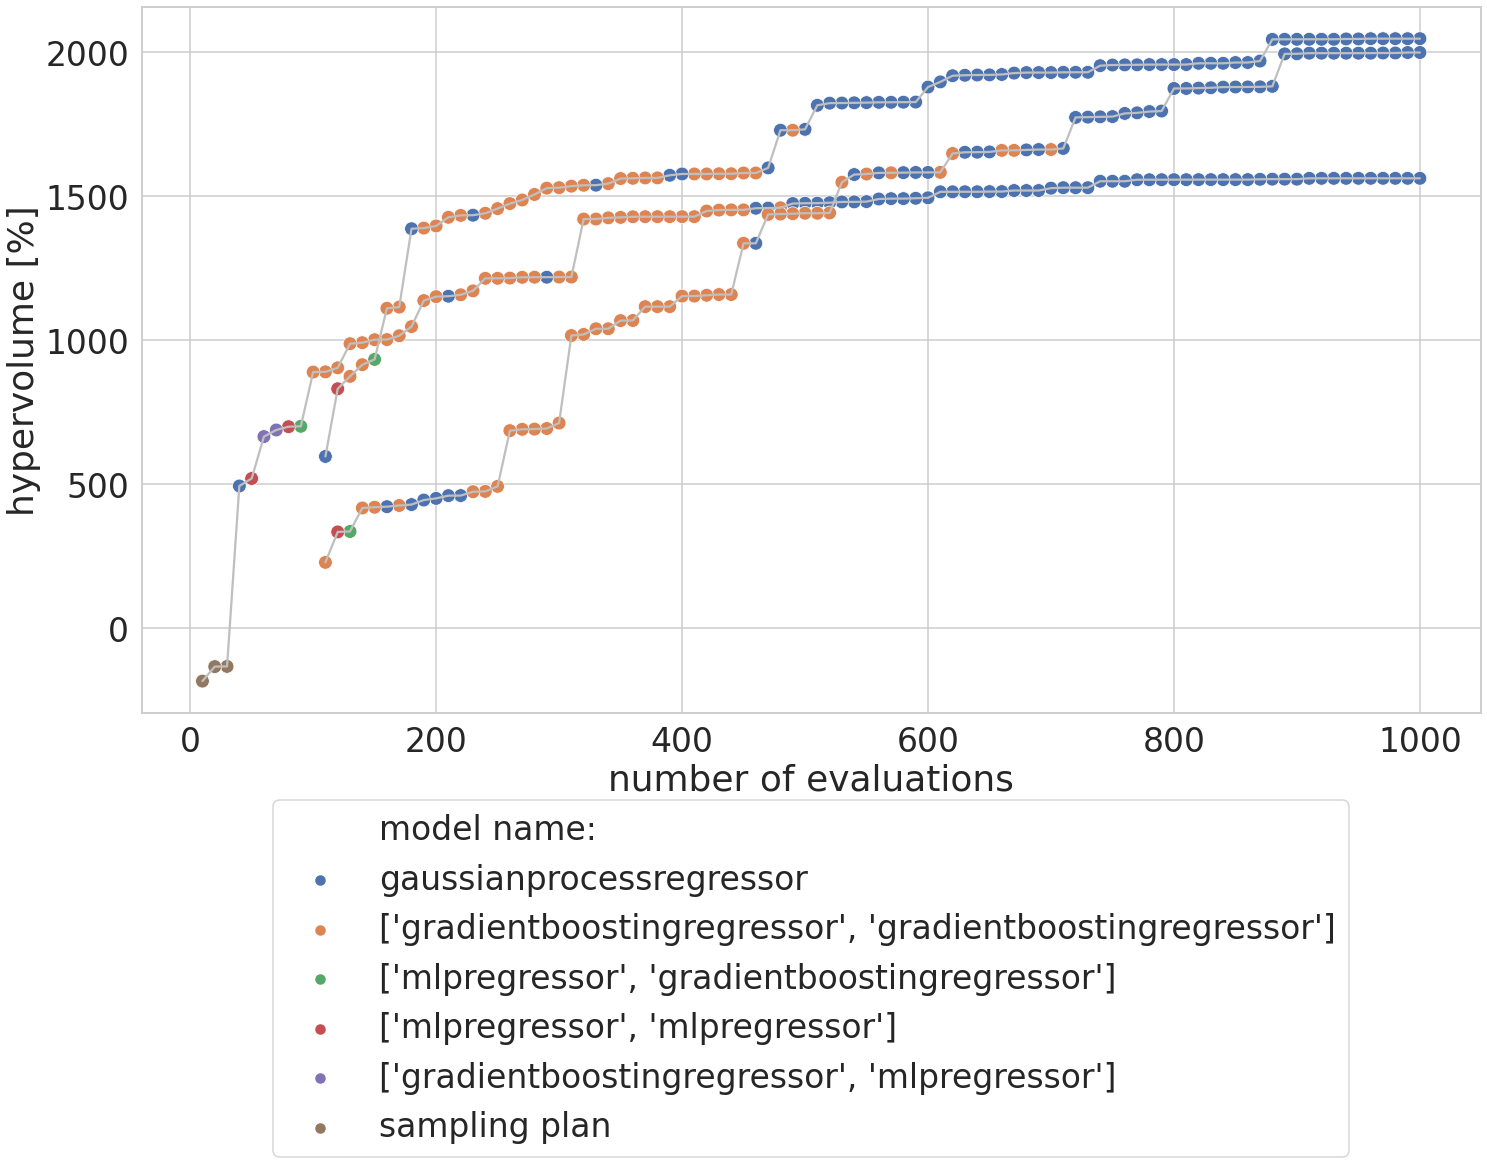

In [42]:
f, axes = plt.subplots(sharex='col', sharey='row')

for i, df_temp in enumerate([b4_df, b1_df, b2_df]):
    df_temp = list(df_temp.groupby('tutor_id'))[EXP_ORDER][1]
    df_temp['model name:'] = df_temp['model name'].astype(str)
    # temp_gpr = df_temp[df_temp['model name'] == 'gaussianprocessregressor']
    # temp_gbr_gbr = df_temp[df_temp['model name'] == "['gradientboostingregressor', 'gradientboostingregressor']"]
    # temp_mlp_gbr = df_temp[df_temp['model name'] == "['mlpregressor', 'gradientboostingregressor']"]
    # temp_mlp_mlp = df_temp[df_temp['model name'] == "['mlpregressor', 'mlpregressor']"]
    # temp_gbr_mlp = df_temp[df_temp['model name'] == "['gradientboostingregressor', 'mlpregressor']"]
    # temp_gbr_mlp




    sns.lineplot(data=df_temp,
                 x="i_fevals", y="hypervolume",
                 #                  color='#eaedee',
                 color='#bfbfbf',
                 )

    sns.scatterplot(data=df_temp,
                    x="i_fevals", y="hypervolume",
                    s=190,
                    hue="model name:",
                    #                 marker='X',
                    ax=axes,
                    legend='brief' if i == 0 else None,
                    palette="deep")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1)
plt.xlabel("number of evaluations")
plt.ylabel("hypervolume [%]")
plt.savefig('model.pdf', bbox_inches = 'tight')

## WFG, ZDT, DTLZ

In [43]:
# --- Static models for all problems
stat_all = get_data('./data/tutorm/paper/solo_model_ZDT_WFG_DTLZ/DTLZ12_10_paper_solo_loop.*.pkl')
stat_all['model name'] = all_prob['model name'].astype(str)
stat_all['group'] = 'static'
stat_all['approach'] = stat_all['model name']

plt.figure(figsize=(24, 12))
p = sns.lineplot(data=stat_all,
                 x="i_fevals", y="ndf_size", 
                 hue="model name", 
                 style="group",
                 palette="deep"
                )
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),  ncol=2)
plt.show(p)

ValueError: No objects to concatenate